# Technical Requirements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')
plt.rc("figure", figsize=(16, 4))

In [2]:
import matplotlib 
import tensorflow as tf

print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
numpy -> {np.__version__}
tensorflow -> {tf.__version__}
''')


Matplotlib -> 3.5.1
pandas -> 1.4.2   
numpy -> 1.22.3
tensorflow -> 2.8.0



In [3]:
###### configurations for image quality#######
# plt.rcParams["figure.figsize"] = [12, 5]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

# Preparing Time Series Data for Deep Learning

In [4]:
path = Path('../../datasets/Ch13/')

In [37]:
weather = pd.read_csv(path.joinpath('jena_climate_2009_2016.csv.zip'), 
                      index_col='DateTime', 
                      usecols=['DateTime','Temperature'], 
                      parse_dates=True)

In [42]:
daily_weather = weather.resample('D').mean()

In [8]:
# store the data set as a csv file
#daily_weather.to_csv(path.joinpath('daily_weather.csv'))

In [5]:
# Read the daily_weather.csv 
daily_weather = pd.read_csv(path.joinpath('daily_weather.csv'), 
                      index_col='DateTime', 
                      parse_dates=True)

In [6]:
energy = pd.read_csv(path.joinpath('energy_consumption.csv'), 
                     index_col='Month', 
                     parse_dates=True)
energy.columns = ['total_energy']

In [7]:
air = pd.read_csv(path.joinpath('air_passenger.csv'), 
                  index_col='date', 
                  parse_dates=True)

### Visualize the time series data

<AxesSubplot:title={'center':'Monthly Passengers'}, xlabel='date'>

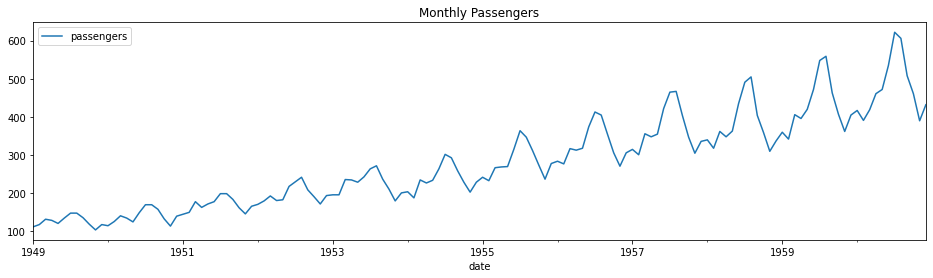

In [7]:
air.plot(title='Monthly Passengers')

<AxesSubplot:title={'center':'Avg Daily Weather Temperature in C'}, xlabel='DateTime'>

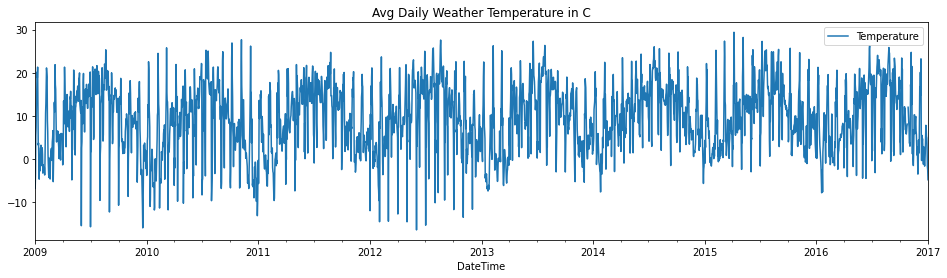

In [8]:
daily_weather.plot(title='Avg Daily Weather Temperature in C')

<AxesSubplot:title={'center':'2012 Avg Daily Weather Temperature Pattern in C'}, xlabel='DateTime'>

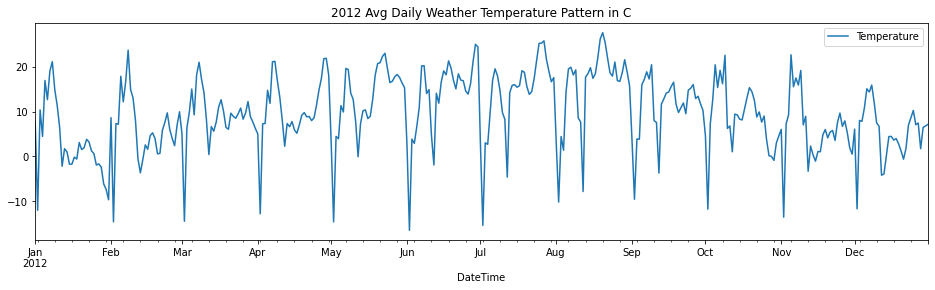

In [9]:
daily_weather.loc['2012'].plot(title='2012 Avg Daily Weather Temperature Pattern in C')

<AxesSubplot:title={'center':'Monthly Energy Consumption'}, xlabel='Month'>

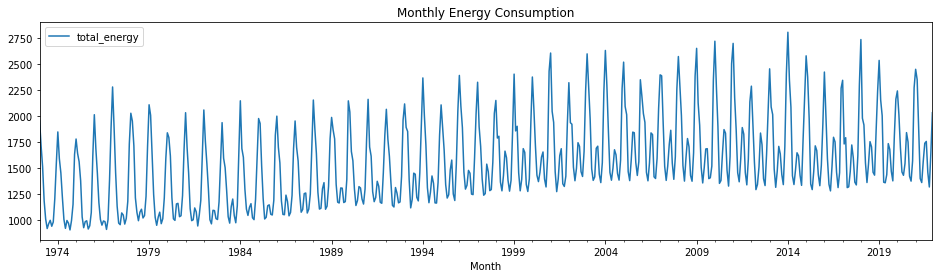

In [10]:
energy.plot(title='Monthly Energy Consumption')

<AxesSubplot:title={'center':'2012-2014 Monthly Energy Consumption Pattern'}, xlabel='Month'>

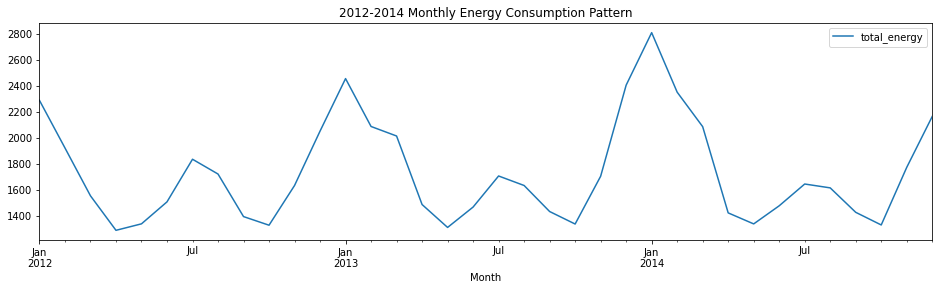

In [11]:
energy.loc['2012':'2014'].plot(title='2012-2014 Monthly Energy Consumption Pattern')

In [12]:
energy.isna().sum()

total_energy    0
dtype: int64

In [8]:
daily_weather.ffill(inplace=True)

In [9]:
daily_weather.isna().sum()

Temperature    0
dtype: int64

In [10]:
air.isna().sum()

passengers    0
dtype: int64

## Tranform the data sets
### Windowing

In [8]:
def one_step_sliding_window(df, steps):
    d = df.values
    x, y = [], []
    n = len(df)
    idx = df.index[:-steps]
    for start in range(n-steps):
        end = start + steps
        x.append(d[start:end].ravel())
        y.append(d[end])
    cols = [f'x_{i}' for i in range(1, steps+1)]
    x_df = pd.DataFrame(np.array(x), columns=cols, index=idx)
    y_df = pd.Series(np.array(y).reshape(-1), name='y', index=idx)
    return pd.concat([x_df, y_df], axis=1)

In [9]:
sliding_window = 5
air_d = one_step_sliding_window(air, sliding_window)
dw_d = one_step_sliding_window(daily_weather, sliding_window)
en_d = one_step_sliding_window(energy, sliding_window)

In [10]:
air_d.head()

,x_1,x_2,x_3,x_4,x_5,y
date,,,,,,
1949-01-31,112,118,132,129,121,135
1949-02-28,118,132,129,121,135,148
1949-03-31,132,129,121,135,148,148
1949-04-30,129,121,135,148,148,136
1949-05-31,121,135,148,148,136,119


In [11]:
dw_d.head()

,x_1,x_2,x_3,x_4,x_5,y
DateTime,,,,,,
2009-01-01,-6.810629,-3.360486,5.435694,7.283889,12.690069,15.201597
2009-01-02,-3.360486,5.435694,7.283889,12.690069,15.201597,20.121875
2009-01-03,5.435694,7.283889,12.690069,15.201597,20.121875,18.864792
2009-01-04,7.283889,12.690069,15.201597,20.121875,18.864792,21.289722
2009-01-05,12.690069,15.201597,20.121875,18.864792,21.289722,11.937847


In [22]:
en_d.head()

,x_1,x_2,x_3,x_4,x_5,y
Month,,,,,,
1973-01-01,1957.641,1712.143,1510.079,1183.421,1006.326,914.949
1973-02-01,1712.143,1510.079,1183.421,1006.326,914.949,961.872
1973-03-01,1510.079,1183.421,1006.326,914.949,961.872,994.259
1973-04-01,1183.421,1006.326,914.949,961.872,994.259,937.083
1973-05-01,1006.326,914.949,961.872,994.259,937.083,978.162


### Scale and split data

In [12]:
class Standardize:
    def __init__(self, df, split=0.15):
        self.data = df
        self.split = split
    
    def _split_data(self):
        n = int(len(self.data) * self.split)
        train, test = self.data.iloc[:-n], self.data.iloc[-n:]
        n = int(len(train) * self.split)
        train, val = train.iloc[:-n], train.iloc[-n:]
        assert len(test) + len(train) + len(val) == len(self.data)
        return train, test, val
    
    def _transform(self, data):
        data_s = (data - self.mu)/self.sigma
        return data_s
    
    def fit(self):
        train, test, val = self._split_data()
        self.mu, self.sigma = train.mean(), train.std()
        train_s = self._transform(train)
        test_s = self._transform(test)
        val_s = self._transform(val)
        return train_s, test_s, val_s
    
    def inverse(self, data):
        return (data * self.sigma)+self.mu
        
    def inverse_y(self, data):
        return (data * self.sigma[-1])+self.mu[-1]


In [13]:
scale_air = Standardize(air_d)
scale_dw = Standardize(dw_d)
scale_en = Standardize(en_d)

train_air, test_air, val_air = scale_air.fit()
train_dw, test_dw, val_dw = scale_dw.fit()
train_en, test_en, val_en = scale_en.fit()

In [14]:
print(f'''
air: train: {len(train_air)} , test: {len(test_air)}, val:{len(val_air)}
weather: train: {len(train_dw)} , test: {len(test_dw)}, val:{len(val_dw)}
energy: train: {len(train_en)} , test: {len(test_en)}, val: {len(val_en)}
''')


air: train: 102 , test: 20, val:17
weather: train: 2109 , test: 437, val:372
energy: train: 422 , test: 87, val: 74



In [15]:
train_air.head()

,x_1,x_2,x_3,x_4,x_5,y
date,,,,,,
1949-01-31,-1.418086,-1.335433,-1.163321,-1.213649,-1.331677,-1.193676
1949-02-28,-1.340522,-1.160959,-1.199458,-1.308609,-1.165784,-1.038787
1949-03-31,-1.159538,-1.198346,-1.295820,-1.142429,-1.011740,-1.038787
1949-04-30,-1.198320,-1.298045,-1.127185,-0.988119,-1.011740,-1.181762
1949-05-31,-1.301740,-1.123572,-0.970596,-0.988119,-1.153934,-1.384309


In [37]:
scale_air.inverse(train_air).head()

,x_1,x_2,x_3,x_4,x_5,y
date,,,,,,
1949-01-31,112.0,118.0,132.0,129.0,121.0,135.0
1949-02-28,118.0,132.0,129.0,121.0,135.0,148.0
1949-03-31,132.0,129.0,121.0,135.0,148.0,148.0
1949-04-30,129.0,121.0,135.0,148.0,148.0,136.0
1949-05-31,121.0,135.0,148.0,148.0,136.0,119.0


### Split into X and Y (Features and Target)

In [15]:
def features_target(*args):
    y = [col.pop('y').values.reshape(-1, 1) for col in args]
    x = [col.values.reshape(*col.shape, 1)
                   for col in args]
    return *y, *x

In [16]:
(y_train_air, 
 y_val_air, 
 y_test_air, 
 x_train_air, 
 x_val_air, 
 x_test_air) = features_target(train_air, 
                               val_air, 
                               test_air)

In [17]:
(y_train_dw, 
y_val_dw, 
y_test_dw, 
x_train_dw, 
x_val_dw, 
x_test_dw) = features_target(train_dw, 
                             val_dw, 
                             test_dw)

In [18]:
(y_train_en, 
y_val_en, 
y_test_en, 
x_train_en, 
x_val_en, 
x_test_en) = features_target(train_en, 
                             val_en, 
                             test_en)

In [19]:
scale_air.inverse_y(y_train_air)[0:5]

array([[135.],
       [148.],
       [148.],
       [136.],
       [119.]])

In [43]:
x_train_air.shape

(102, 5, 1)

In [44]:
print(y_train_air.shape,
y_test_air.shape,
y_val_air.shape)

(102, 1) (20, 1) (17, 1)


## There is more

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [46]:
train, test = train_test_split(air_d, test_size=0.15, shuffle=False)
train, val = train_test_split(train, test_size=0.15, shuffle=False)

In [48]:
scale = StandardScaler()
scale.fit(train)

StandardScaler()

In [49]:
train_scaled = scale.transform(train)
test_scaled = scale.transform(test)
val_scaled = scale.transform(val)

In [50]:
x_train, y_train = train_scaled[:, :-1], train_scaled[:, -1]
x_test, y_test = test_scaled[:, :-1], test_scaled[:, -1]
x_val, y_val = val_scaled[:, :-1], val_scaled[:, -1]

# Forecasting with Keras

In [20]:
from tensorflow.keras import Sequential
from tensorflow import keras
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from keras.layers import (BatchNormalization, Dense,  
                TimeDistributed, Bidirectional, 
                SimpleRNN, GRU, LSTM, Dropout)

## SimpleRNN

In [21]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(SimpleRNN(units=units,
                        return_sequences=False,
                        input_shape=(train.shape[1], 
                                     train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

In [22]:
def train_model(model, 
                x_train, 
                y_train, 
                x_val, 
                y_val, 
                epochs=100, 
                patience=8, 
                batch_size=32):
    
    model.compile(optimizer='adam', 
                  loss='mean_squared_error', 
                  metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
    
    es = keras.callbacks.EarlyStopping(monitor="val_loss", 
                                       min_delta=0, 
                                       patience=patience)
    
    history = model.fit(x_train,
              y_train, 
              shuffle=False, 
              epochs=epochs,
              batch_size=batch_size, 
              validation_data=(x_val, y_val),
              callbacks=[es],
              verbose=1)
    return history

In [23]:
def plot_forecast(model, x_test, y_test, index, history):
    plt.figure(figsize=(20, 10))
    ax1 = plt.subplot2grid((2, 2), (0, 0))
    pd.Series(history.history['root_mean_squared_error']).plot(ax=ax1, 
                                                               title='RMSE by EPOCH',
                                                              label='rmse')
    pd.Series(history.history['val_root_mean_squared_error']).plot(ax=ax1,
                                                                  label='val_rmse')
    plt.legend()

    ax2 = plt.subplot2grid((2, 2), (0, 1))
    pd.Series(history.history['mean_absolute_error']).plot(ax=ax2,
                                                          title='MAE by EPOCH',
                                                          label='mae')
    pd.Series(history.history['val_mean_absolute_error']).plot(ax=ax2,
                                                              label='val_mae')
    plt.legend()
    ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
    predicted = model.predict(x_test)
    pd.Series(y_test.reshape(-1), 
              index=index).plot(style='k--', alpha=0.5, ax=ax3, 
                                title='Forecast vs Actual',
                               label='actual')
    pd.Series(predicted.reshape(-1), 
              index=index).plot(style='k', label='Forecast', ax=ax3)
    plt.legend();plt.show()


### Air Passenger

In [24]:
model_a_simpleRNN = create_model(train=x_train_air, units=32)

2022-04-20 06:09:20.831886: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
model_a_simpleRNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [26]:
history_a_simpleRNN = train_model(model_a_simpleRNN, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/100
4/4 [==============================] - 1s 76ms/step - loss: 0.9027 - root_mean_squared_error: 0.9501 - mean_absolute_error: 0.7418 - val_loss: 2.1126 - val_root_mean_squared_error: 1.4535 - val_mean_absolute_error: 1.2884
Epoch 2/100
4/4 [==============================] - 0s 9ms/step - loss: 0.5733 - root_mean_squared_error: 0.7572 - mean_absolute_error: 0.6072 - val_loss: 1.4037 - val_root_mean_squared_error: 1.1848 - val_mean_absolute_error: 0.9669
Epoch 3/100
4/4 [==============================] - 0s 10ms/step - loss: 0.3675 - root_mean_squared_error: 0.6062 - mean_absolute_error: 0.4869 - val_loss: 0.9520 - val_root_mean_squared_error: 0.9757 - val_mean_absolute_error: 0.7112
Epoch 4/100
4/4 [==============================] - 0s 9ms/step - loss: 0.3255 - root_mean_squared_error: 0.5705 - mean_absolute_error: 0.4663 - val_loss: 0.6923 - val_root_mean_squared_error: 0.8320 - val_mean_absolute_error: 0.5845
Epoch 5/100
4/4 [==============================] - 0s 9ms/step - l

In [27]:
history_a_simpleRNN.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_root_mean_squared_error', 'val_mean_absolute_error'])

In [28]:
model_a_simpleRNN.evaluate(x=x_test_air, y=y_test_air)

1/1 [==============================] - 0s 22ms/step - loss: 0.8080 - root_mean_squared_error: 0.8989 - mean_absolute_error: 0.7479


[0.8080040812492371, 0.898890495300293, 0.7478644847869873]

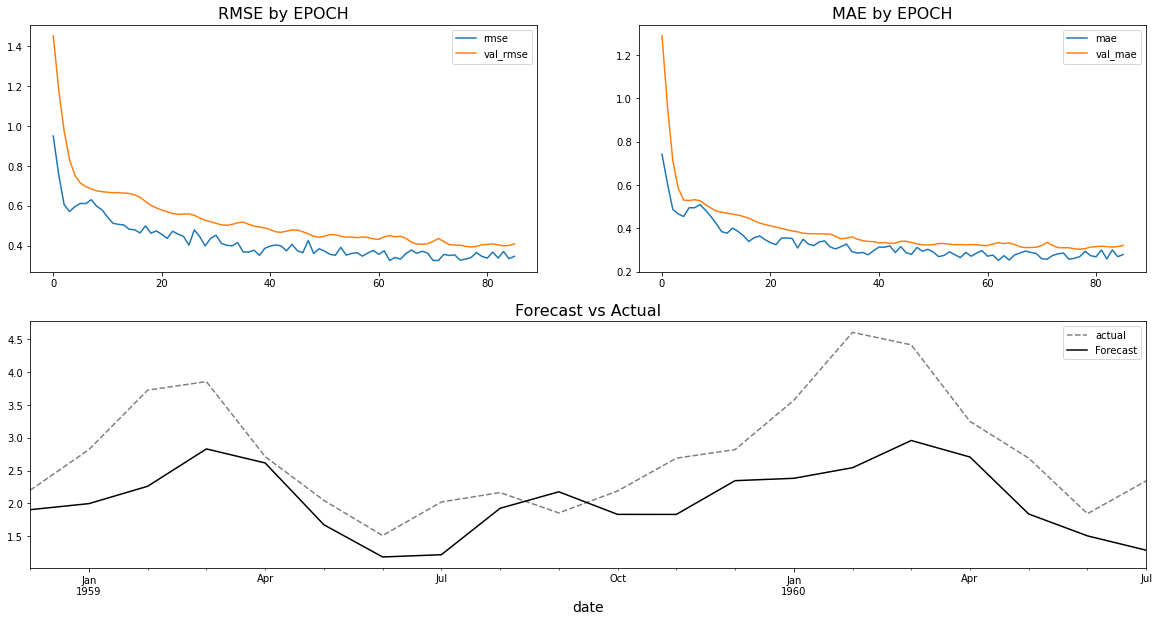

In [29]:
plot_forecast(model_a_simpleRNN, x_test_air, y_test_air, test_air.index, history_a_simpleRNN)

### Avg Daily Temp

In [30]:
model_dw_simpleRNN = create_model(x_train_dw, units=32)

In [31]:
model_dw_simpleRNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 32)                1088      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [32]:
history_dw_simpleRNN = train_model(model_dw_simpleRNN, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)

Epoch 1/100
33/33 [==============================] - 1s 8ms/step - loss: 1.1901 - root_mean_squared_error: 1.0909 - mean_absolute_error: 0.8585 - val_loss: 0.6076 - val_root_mean_squared_error: 0.7795 - val_mean_absolute_error: 0.6124
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 0.7405 - root_mean_squared_error: 0.8605 - mean_absolute_error: 0.6603 - val_loss: 0.4783 - val_root_mean_squared_error: 0.6916 - val_mean_absolute_error: 0.5384
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 0.6258 - root_mean_squared_error: 0.7911 - mean_absolute_error: 0.5993 - val_loss: 0.4105 - val_root_mean_squared_error: 0.6407 - val_mean_absolute_error: 0.4942
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 0.5548 - root_mean_squared_error: 0.7449 - mean_absolute_error: 0.5587 - val_loss: 0.3669 - val_root_mean_squared_error: 0.6057 - val_mean_absolute_error: 0.4657
Epoch 5/100
33/33 [==============================] - 0s 3ms/

In [33]:
model_dw_simpleRNN.evaluate(x=x_test_dw, y=y_test_dw)

14/14 [==============================] - 0s 2ms/step - loss: nan - root_mean_squared_error: nan - mean_absolute_error: nan     


[nan, nan, nan]

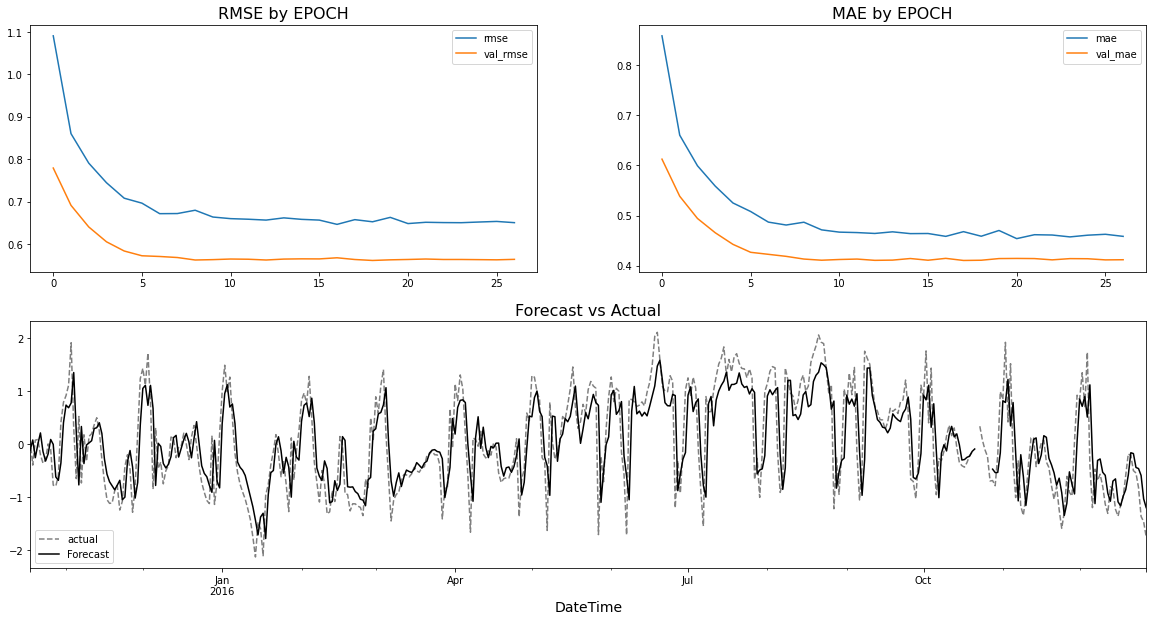

In [34]:
plot_forecast(model_dw_simpleRNN, x_test_dw, y_test_dw, test_dw.index, history_dw_simpleRNN)

### Energy Consumption

In [35]:
model_en_simpleRNN = create_model(x_train_en, units=32)
model_en_simpleRNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 32)                1088      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [36]:
history_en_simpleRNN = train_model(model_en_simpleRNN, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)

Epoch 1/100
7/7 [==============================] - 1s 33ms/step - loss: 1.1759 - root_mean_squared_error: 1.0844 - mean_absolute_error: 0.8728 - val_loss: 1.8491 - val_root_mean_squared_error: 1.3598 - val_mean_absolute_error: 0.9961
Epoch 2/100
7/7 [==============================] - 0s 6ms/step - loss: 0.9979 - root_mean_squared_error: 0.9989 - mean_absolute_error: 0.7989 - val_loss: 1.5546 - val_root_mean_squared_error: 1.2468 - val_mean_absolute_error: 0.9224
Epoch 3/100
7/7 [==============================] - 0s 6ms/step - loss: 0.8352 - root_mean_squared_error: 0.9139 - mean_absolute_error: 0.7430 - val_loss: 1.2916 - val_root_mean_squared_error: 1.1365 - val_mean_absolute_error: 0.8392
Epoch 4/100
7/7 [==============================] - 0s 6ms/step - loss: 0.7384 - root_mean_squared_error: 0.8593 - mean_absolute_error: 0.6939 - val_loss: 1.0953 - val_root_mean_squared_error: 1.0466 - val_mean_absolute_error: 0.7638
Epoch 5/100
7/7 [==============================] - 0s 6ms/step - lo

In [37]:
model_en_simpleRNN.evaluate(x=x_test_en, y=y_test_en)

3/3 [==============================] - 0s 2ms/step - loss: 0.2676 - root_mean_squared_error: 0.5173 - mean_absolute_error: 0.4050


[0.26764723658561707, 0.5173463225364685, 0.40502938628196716]

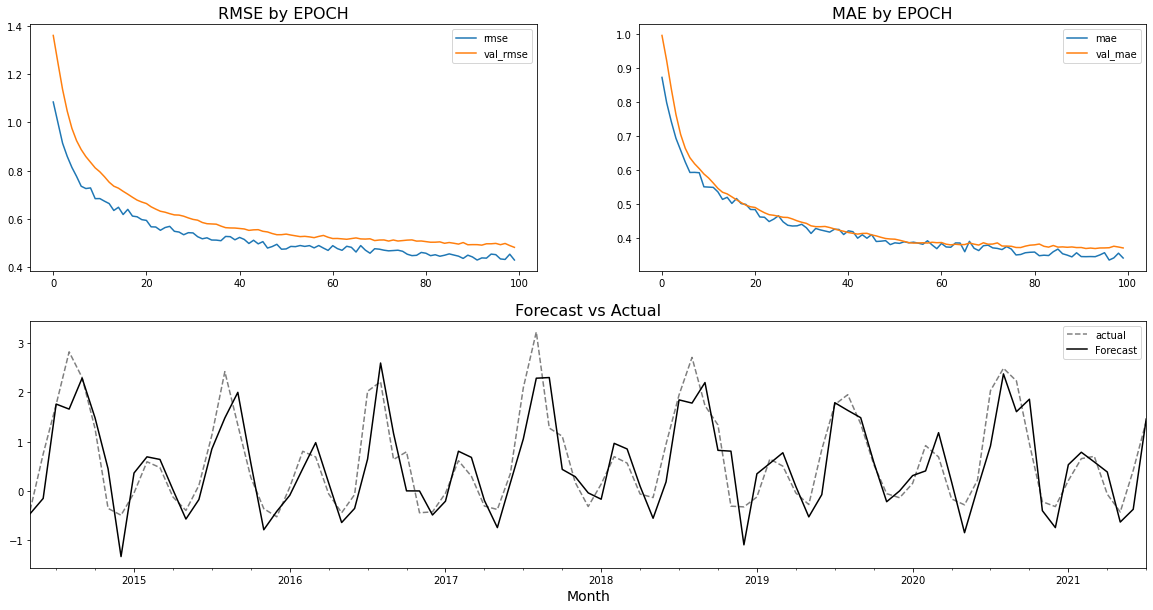

In [38]:
plot_forecast(model_en_simpleRNN, x_test_en, y_test_en, test_en.index, history_en_simpleRNN)

## LSTM

In [39]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units,
                   input_shape=(train.shape[1], 
                                train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

### Air Passenger

In [40]:
model_a_lstm = create_model(train=x_train_air, units=32)
model_a_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [41]:
history_a_lstm = train_model(model_a_lstm, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/100
4/4 [==============================] - 2s 147ms/step - loss: 1.2903 - root_mean_squared_error: 1.1359 - mean_absolute_error: 0.9338 - val_loss: 4.0861 - val_root_mean_squared_error: 2.0214 - val_mean_absolute_error: 1.9024
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 1.1914 - root_mean_squared_error: 1.0915 - mean_absolute_error: 0.8890 - val_loss: 3.7682 - val_root_mean_squared_error: 1.9412 - val_mean_absolute_error: 1.8160
Epoch 3/100
4/4 [==============================] - 0s 12ms/step - loss: 1.1120 - root_mean_squared_error: 1.0545 - mean_absolute_error: 0.8550 - val_loss: 3.4709 - val_root_mean_squared_error: 1.8630 - val_mean_absolute_error: 1.7312
Epoch 4/100
4/4 [==============================] - 0s 18ms/step - loss: 1.0359 - root_mean_squared_error: 1.0178 - mean_absolute_error: 0.8233 - val_loss: 3.1968 - val_root_mean_squared_error: 1.7880 - val_mean_absolute_error: 1.6492
Epoch 5/100
4/4 [==============================] - 0s 12ms/step

In [42]:
model_a_lstm.evaluate(x=x_test_air, y=y_test_air)

1/1 [==============================] - 0s 22ms/step - loss: 1.3974 - root_mean_squared_error: 1.1821 - mean_absolute_error: 0.9141


[1.3973956108093262, 1.182114839553833, 0.9141407012939453]

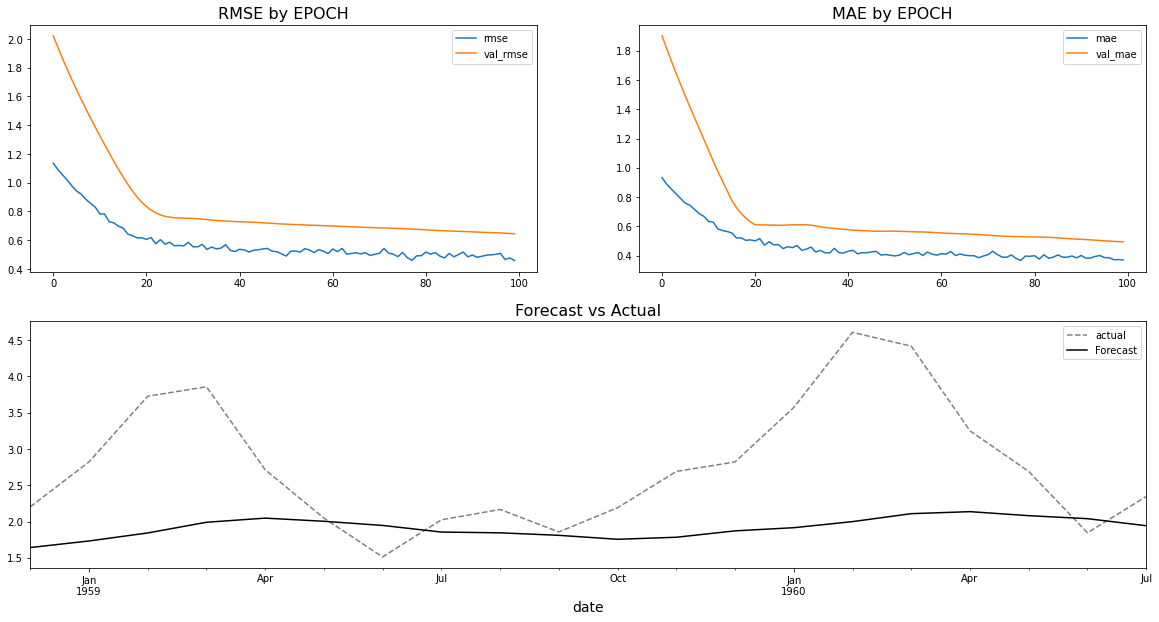

In [43]:
plot_forecast(model_a_lstm, x_test_air, y_test_air, test_air.index, history_a_lstm)

### Avg Daily Temp

In [44]:
model_dw_lstm = create_model(train=x_train_dw, units=32)
model_dw_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4352      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [45]:
history_dw_lstm = train_model(model_dw_lstm, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)

Epoch 1/100
33/33 [==============================] - 2s 16ms/step - loss: 0.8455 - root_mean_squared_error: 0.9195 - mean_absolute_error: 0.7505 - val_loss: 0.5890 - val_root_mean_squared_error: 0.7674 - val_mean_absolute_error: 0.5972
Epoch 2/100
33/33 [==============================] - 0s 4ms/step - loss: 0.7252 - root_mean_squared_error: 0.8516 - mean_absolute_error: 0.6717 - val_loss: 0.5335 - val_root_mean_squared_error: 0.7304 - val_mean_absolute_error: 0.5518
Epoch 3/100
33/33 [==============================] - 0s 5ms/step - loss: 0.6698 - root_mean_squared_error: 0.8184 - mean_absolute_error: 0.6344 - val_loss: 0.4945 - val_root_mean_squared_error: 0.7032 - val_mean_absolute_error: 0.5319
Epoch 4/100
33/33 [==============================] - 0s 5ms/step - loss: 0.6227 - root_mean_squared_error: 0.7891 - mean_absolute_error: 0.6072 - val_loss: 0.4583 - val_root_mean_squared_error: 0.6770 - val_mean_absolute_error: 0.5128
Epoch 5/100
33/33 [==============================] - 0s 5ms

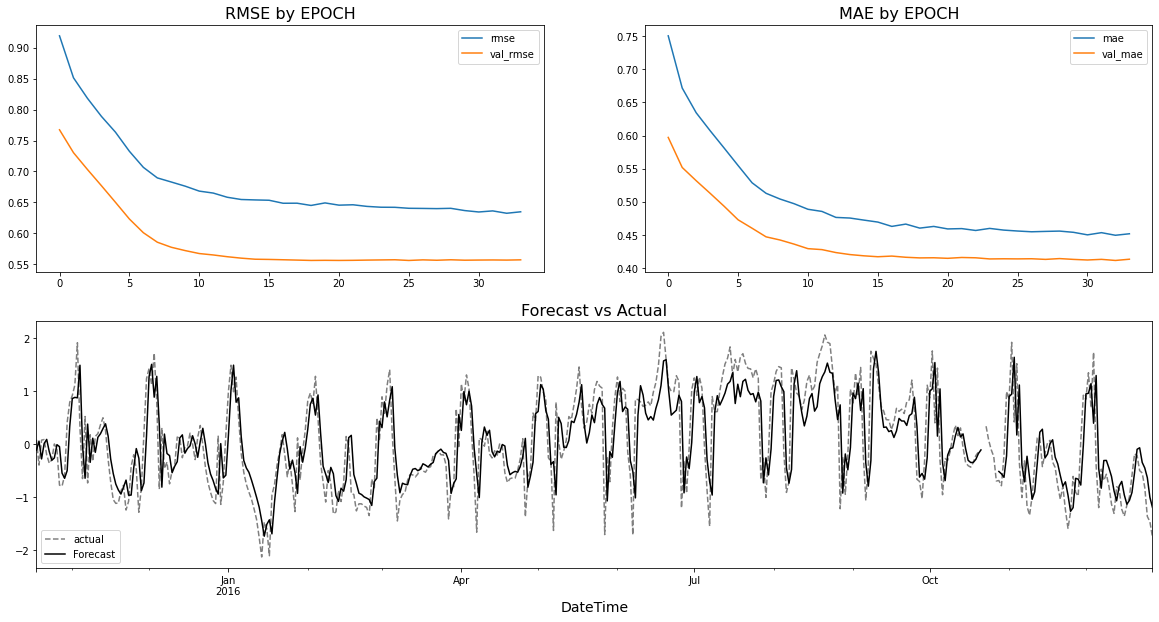

In [46]:
plot_forecast(model_dw_lstm, x_test_dw, y_test_dw, test_dw.index, history_dw_lstm)

### Energy Consumption

In [47]:
model_en_lstm = create_model(train=x_train_en, units=32)
model_en_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32)                4352      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [48]:
history_en_lstm = train_model(model_en_lstm, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)

Epoch 1/100
7/7 [==============================] - 2s 67ms/step - loss: 1.1884 - root_mean_squared_error: 1.0902 - mean_absolute_error: 0.8883 - val_loss: 1.8349 - val_root_mean_squared_error: 1.3546 - val_mean_absolute_error: 0.9432
Epoch 2/100
7/7 [==============================] - 0s 8ms/step - loss: 1.1175 - root_mean_squared_error: 1.0571 - mean_absolute_error: 0.8659 - val_loss: 1.7584 - val_root_mean_squared_error: 1.3260 - val_mean_absolute_error: 0.9209
Epoch 3/100
7/7 [==============================] - 0s 8ms/step - loss: 1.0826 - root_mean_squared_error: 1.0405 - mean_absolute_error: 0.8516 - val_loss: 1.6882 - val_root_mean_squared_error: 1.2993 - val_mean_absolute_error: 0.9004
Epoch 4/100
7/7 [==============================] - 0s 8ms/step - loss: 1.0419 - root_mean_squared_error: 1.0208 - mean_absolute_error: 0.8388 - val_loss: 1.6272 - val_root_mean_squared_error: 1.2756 - val_mean_absolute_error: 0.8848
Epoch 5/100
7/7 [==============================] - 0s 8ms/step - lo

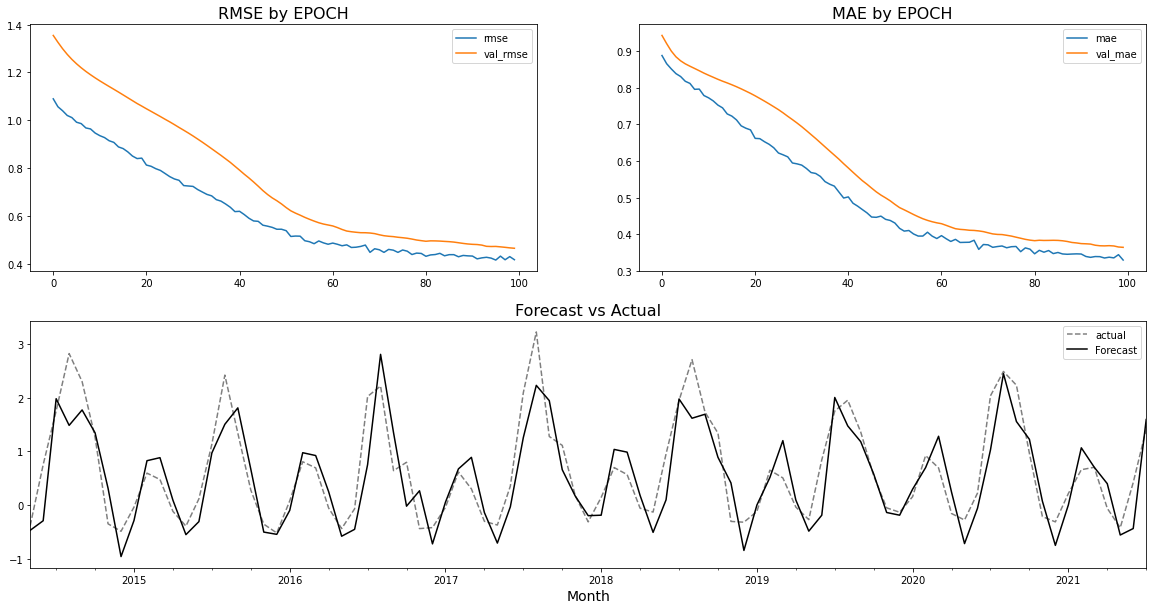

In [49]:
plot_forecast(model_en_lstm, x_test_en, y_test_en, test_en.index, history_en_lstm)

## GRU

In [50]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(GRU(units=units,
                  input_shape=(train.shape[1], 
                               train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

### Air Passenger

In [51]:
model_a_gru = create_model(train=x_train_air, units=32)
history_a_gru = train_model(model_a_gru, x_train_air, y_train_air, x_val_air, y_val_air)


Epoch 1/100
4/4 [==============================] - 2s 126ms/step - loss: 0.6368 - root_mean_squared_error: 0.7980 - mean_absolute_error: 0.6472 - val_loss: 1.8999 - val_root_mean_squared_error: 1.3784 - val_mean_absolute_error: 1.2272
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 0.5586 - root_mean_squared_error: 0.7474 - mean_absolute_error: 0.5943 - val_loss: 1.5952 - val_root_mean_squared_error: 1.2630 - val_mean_absolute_error: 1.0951
Epoch 3/100
4/4 [==============================] - 0s 12ms/step - loss: 0.4701 - root_mean_squared_error: 0.6856 - mean_absolute_error: 0.5528 - val_loss: 1.3194 - val_root_mean_squared_error: 1.1487 - val_mean_absolute_error: 0.9642
Epoch 4/100
4/4 [==============================] - 0s 12ms/step - loss: 0.4121 - root_mean_squared_error: 0.6419 - mean_absolute_error: 0.5099 - val_loss: 1.0809 - val_root_mean_squared_error: 1.0397 - val_mean_absolute_error: 0.8482
Epoch 5/100
4/4 [==============================] - 0s 13ms/step

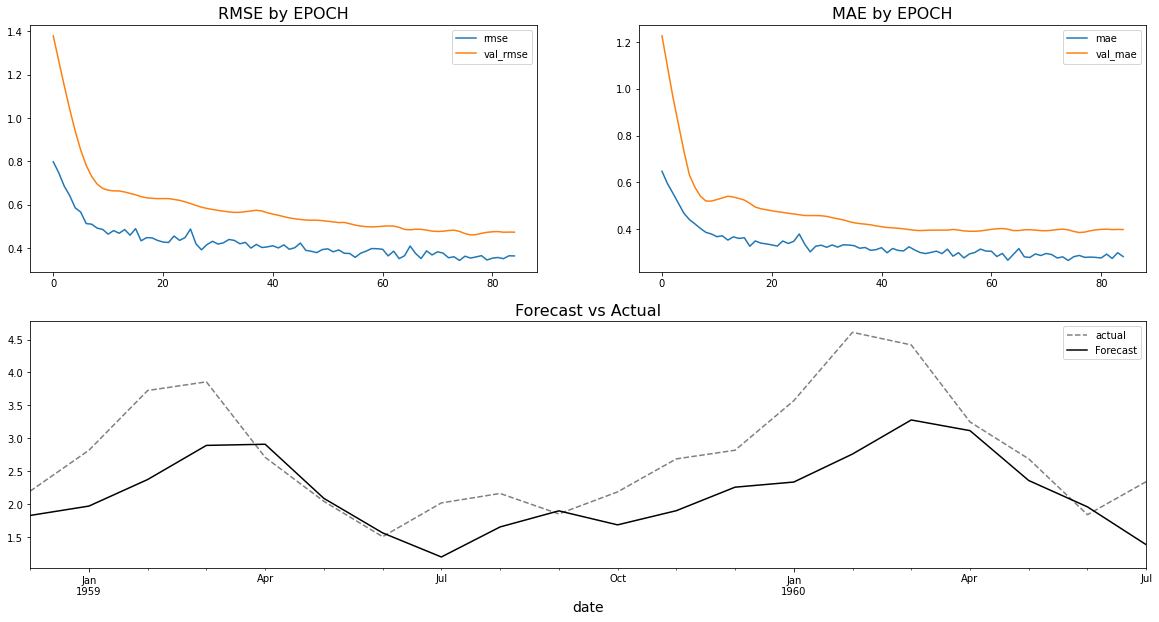

In [52]:
plot_forecast(model_a_gru, x_test_air, y_test_air, test_air.index, history_a_gru)

### Avg Daily Temp

In [53]:
model_dw_gru = create_model(train=x_train_dw, units=32)
history_dw_gru = train_model(model_dw_gru, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)

Epoch 1/100
33/33 [==============================] - 2s 17ms/step - loss: 1.0159 - root_mean_squared_error: 1.0079 - mean_absolute_error: 0.8324 - val_loss: 0.6202 - val_root_mean_squared_error: 0.7876 - val_mean_absolute_error: 0.6240
Epoch 2/100
33/33 [==============================] - 0s 5ms/step - loss: 0.7066 - root_mean_squared_error: 0.8406 - mean_absolute_error: 0.6613 - val_loss: 0.4908 - val_root_mean_squared_error: 0.7006 - val_mean_absolute_error: 0.5263
Epoch 3/100
33/33 [==============================] - 0s 5ms/step - loss: 0.6070 - root_mean_squared_error: 0.7791 - mean_absolute_error: 0.5919 - val_loss: 0.4318 - val_root_mean_squared_error: 0.6571 - val_mean_absolute_error: 0.4920
Epoch 4/100
33/33 [==============================] - 0s 4ms/step - loss: 0.5506 - root_mean_squared_error: 0.7420 - mean_absolute_error: 0.5587 - val_loss: 0.3878 - val_root_mean_squared_error: 0.6228 - val_mean_absolute_error: 0.4657
Epoch 5/100
33/33 [==============================] - 0s 4ms

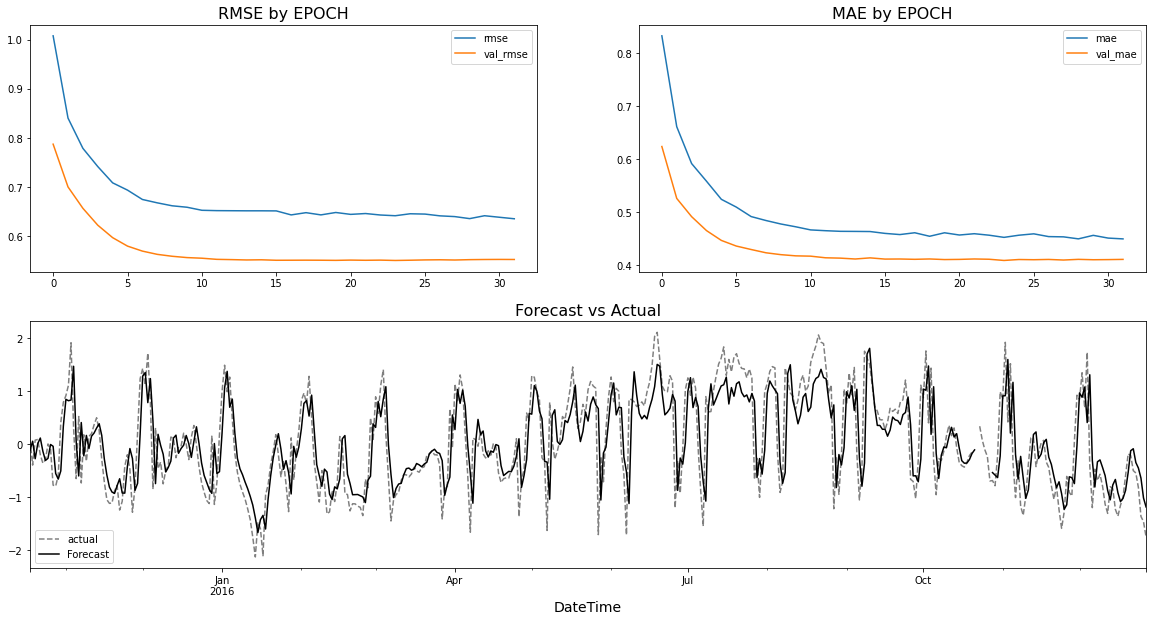

In [54]:
plot_forecast(model_dw_gru, x_test_dw, y_test_dw, test_dw.index, history_dw_gru)

### Energy Consumption

In [55]:
model_en_gru = create_model(x_train_en, units=32)
model_en_gru.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 32)                3360      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


In [56]:
history_en_gru = train_model(model_en_gru, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)

Epoch 1/100
7/7 [==============================] - 2s 66ms/step - loss: 1.0487 - root_mean_squared_error: 1.0241 - mean_absolute_error: 0.8382 - val_loss: 1.6312 - val_root_mean_squared_error: 1.2772 - val_mean_absolute_error: 0.8912
Epoch 2/100
7/7 [==============================] - 0s 9ms/step - loss: 0.9698 - root_mean_squared_error: 0.9848 - mean_absolute_error: 0.8090 - val_loss: 1.5349 - val_root_mean_squared_error: 1.2389 - val_mean_absolute_error: 0.8758
Epoch 3/100
7/7 [==============================] - 0s 10ms/step - loss: 0.9229 - root_mean_squared_error: 0.9607 - mean_absolute_error: 0.7889 - val_loss: 1.4473 - val_root_mean_squared_error: 1.2030 - val_mean_absolute_error: 0.8616
Epoch 4/100
7/7 [==============================] - 0s 8ms/step - loss: 0.8793 - root_mean_squared_error: 0.9377 - mean_absolute_error: 0.7717 - val_loss: 1.3706 - val_root_mean_squared_error: 1.1707 - val_mean_absolute_error: 0.8485
Epoch 5/100
7/7 [==============================] - 0s 8ms/step - l

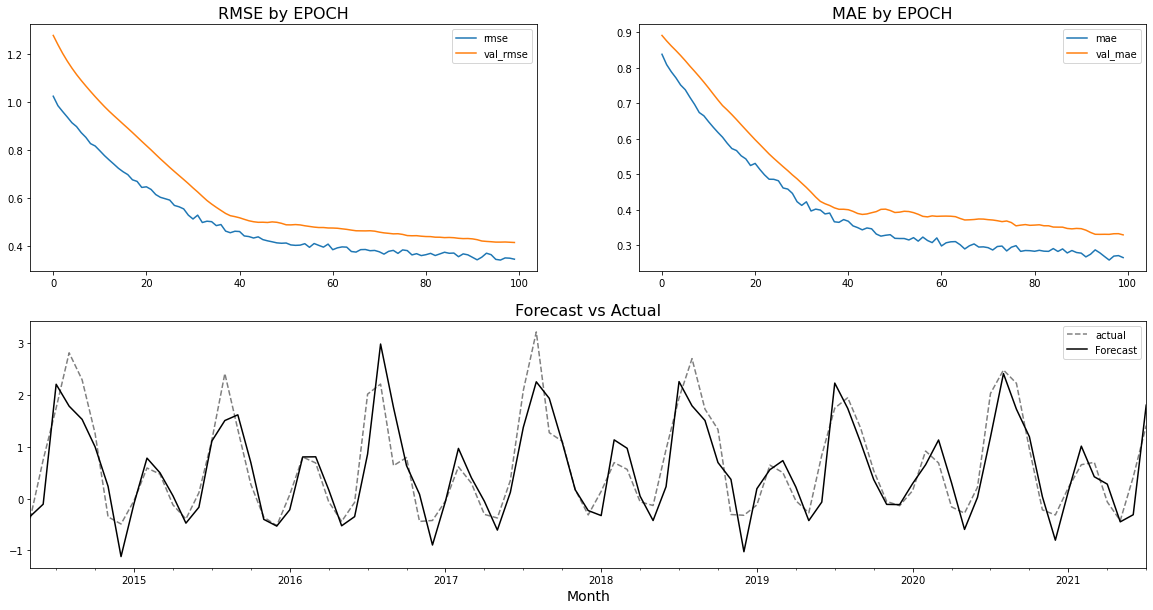

In [57]:
plot_forecast(model_en_gru, x_test_en, y_test_en, test_en.index, history_en_gru)

## Deep RNN-LSTM

### Air Passenger

In [58]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units,input_shape=(train.shape[1], train.shape[2]), return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

In [59]:
model_a_deep = create_model(train=x_train_air, units=32)
history_a_deep = train_model(model_a_deep, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/100
4/4 [==============================] - 4s 262ms/step - loss: 1.0143 - root_mean_squared_error: 1.0071 - mean_absolute_error: 0.8195 - val_loss: 3.2269 - val_root_mean_squared_error: 1.7964 - val_mean_absolute_error: 1.6736
Epoch 2/100
4/4 [==============================] - 0s 15ms/step - loss: 0.9211 - root_mean_squared_error: 0.9597 - mean_absolute_error: 0.7772 - val_loss: 2.8878 - val_root_mean_squared_error: 1.6993 - val_mean_absolute_error: 1.5663
Epoch 3/100
4/4 [==============================] - 0s 15ms/step - loss: 0.8240 - root_mean_squared_error: 0.9078 - mean_absolute_error: 0.7360 - val_loss: 2.5619 - val_root_mean_squared_error: 1.6006 - val_mean_absolute_error: 1.4553
Epoch 4/100
4/4 [==============================] - 0s 16ms/step - loss: 0.7338 - root_mean_squared_error: 0.8566 - mean_absolute_error: 0.6936 - val_loss: 2.2459 - val_root_mean_squared_error: 1.4986 - val_mean_absolute_error: 1.3383
Epoch 5/100
4/4 [==============================] - 0s 18ms/step

In [60]:
model_a_deep.evaluate(x_test_air, y_test_air)

1/1 [==============================] - 0s 25ms/step - loss: 1.6466 - root_mean_squared_error: 1.2832 - mean_absolute_error: 1.1452


[1.646583914756775, 1.2831928730010986, 1.145249605178833]

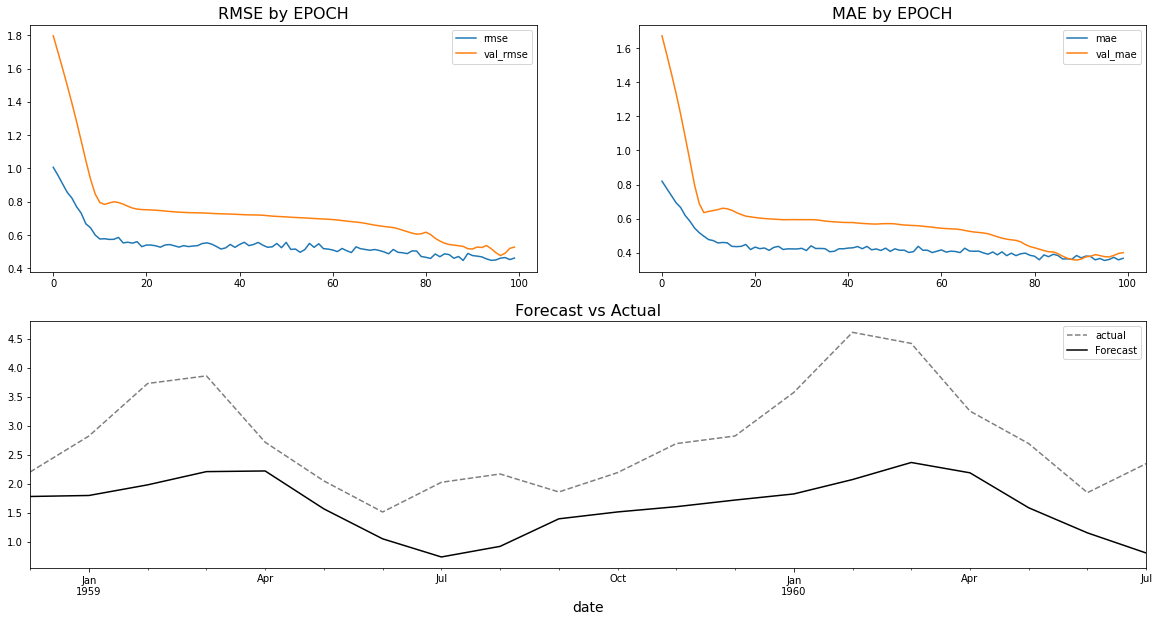

In [61]:
plot_forecast(model_a_deep, x_test_air, y_test_air, test_air.index, history_a_deep)

### Avg Daily Temp

Epoch 1/100
33/33 [==============================] - 4s 31ms/step - loss: 0.8904 - root_mean_squared_error: 0.9436 - mean_absolute_error: 0.7758 - val_loss: 0.6381 - val_root_mean_squared_error: 0.7988 - val_mean_absolute_error: 0.6237
Epoch 2/100
33/33 [==============================] - 0s 7ms/step - loss: 0.7854 - root_mean_squared_error: 0.8862 - mean_absolute_error: 0.7021 - val_loss: 0.5878 - val_root_mean_squared_error: 0.7667 - val_mean_absolute_error: 0.5840
Epoch 3/100
33/33 [==============================] - 0s 6ms/step - loss: 0.7226 - root_mean_squared_error: 0.8500 - mean_absolute_error: 0.6665 - val_loss: 0.5360 - val_root_mean_squared_error: 0.7321 - val_mean_absolute_error: 0.5597
Epoch 4/100
33/33 [==============================] - 0s 6ms/step - loss: 0.6472 - root_mean_squared_error: 0.8045 - mean_absolute_error: 0.6257 - val_loss: 0.4634 - val_root_mean_squared_error: 0.6807 - val_mean_absolute_error: 0.5252
Epoch 5/100
33/33 [==============================] - 0s 6ms

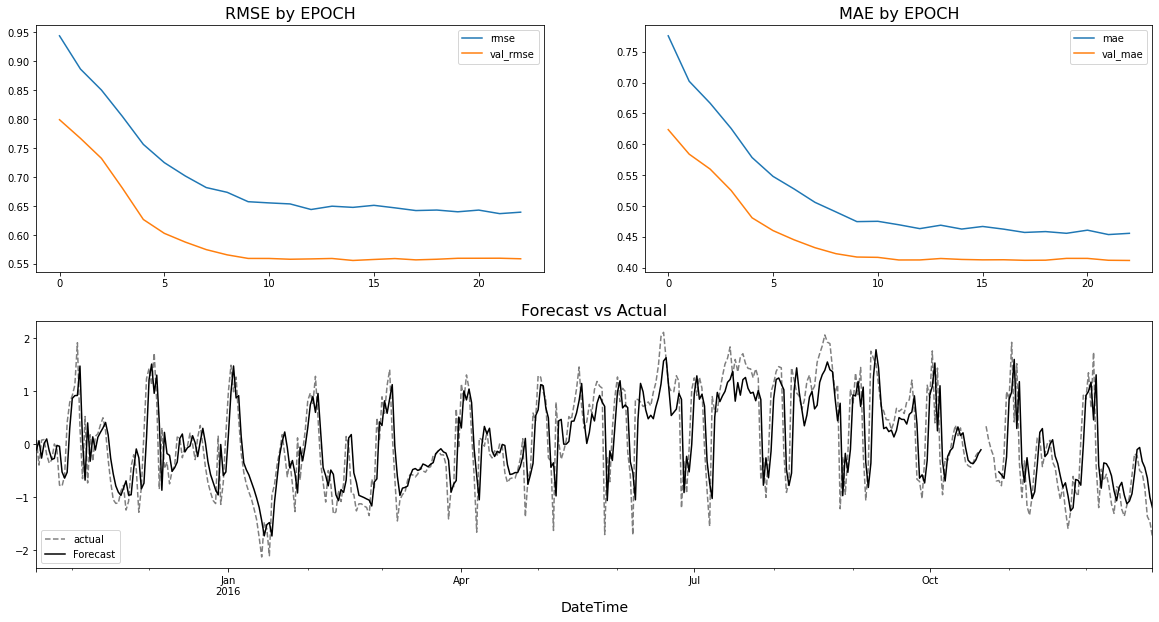

In [62]:
model_dw_deep = create_model(x_train_dw, units=32)
history_dw_deep = train_model(model_dw_deep, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)
plot_forecast(model_dw_deep, x_test_dw, y_test_dw, test_dw.index, history_dw_deep)

### Energy Consumption

Epoch 1/100
7/7 [==============================] - 4s 146ms/step - loss: 1.0202 - root_mean_squared_error: 1.0100 - mean_absolute_error: 0.8248 - val_loss: 1.6067 - val_root_mean_squared_error: 1.2675 - val_mean_absolute_error: 0.8847
Epoch 2/100
7/7 [==============================] - 0s 14ms/step - loss: 0.9874 - root_mean_squared_error: 0.9937 - mean_absolute_error: 0.8135 - val_loss: 1.5551 - val_root_mean_squared_error: 1.2470 - val_mean_absolute_error: 0.8712
Epoch 3/100
7/7 [==============================] - 0s 13ms/step - loss: 0.9662 - root_mean_squared_error: 0.9830 - mean_absolute_error: 0.8075 - val_loss: 1.5110 - val_root_mean_squared_error: 1.2292 - val_mean_absolute_error: 0.8651
Epoch 4/100
7/7 [==============================] - 0s 12ms/step - loss: 0.9551 - root_mean_squared_error: 0.9773 - mean_absolute_error: 0.8053 - val_loss: 1.4763 - val_root_mean_squared_error: 1.2150 - val_mean_absolute_error: 0.8609
Epoch 5/100
7/7 [==============================] - 0s 11ms/step

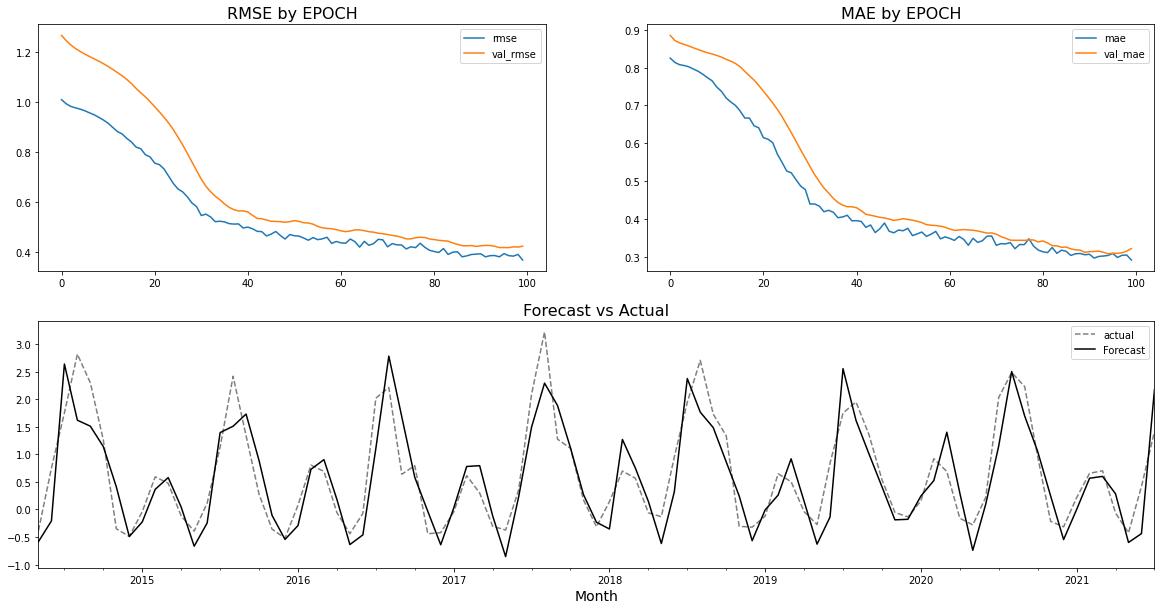

In [63]:
model_en_deep = create_model(x_train_en, units=32)
history_en_deep = train_model(model_en_deep, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)
plot_forecast(model_en_deep, x_test_en, y_test_en, test_en.index, history_en_deep)

## Bidirectional

In [411]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(Bidirectional(LSTM(units=units, input_shape=(train.shape[1], train.shape[2]), return_sequences=True)))
    model.add(Dropout(dropout))
    # model.add(TimeDistributed(Dense(1)))
    model.add(Dense(1))
    
    return model

### Air Passenger

In [412]:
model_a_bd = create_model(train=x_train_air, units=32)
history_a_bd = train_model(model_a_bd, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/100
4/4 [==============================] - 4s 231ms/step - loss: 0.8102 - root_mean_squared_error: 0.9001 - mean_absolute_error: 0.7600 - val_loss: 2.2789 - val_root_mean_squared_error: 1.5096 - val_mean_absolute_error: 1.3668
Epoch 2/100
4/4 [==============================] - 0s 16ms/step - loss: 0.7157 - root_mean_squared_error: 0.8460 - mean_absolute_error: 0.7092 - val_loss: 2.0195 - val_root_mean_squared_error: 1.4211 - val_mean_absolute_error: 1.2646
Epoch 3/100
4/4 [==============================] - 0s 18ms/step - loss: 0.6242 - root_mean_squared_error: 0.7901 - mean_absolute_error: 0.6568 - val_loss: 1.7716 - val_root_mean_squared_error: 1.3310 - val_mean_absolute_error: 1.1581
Epoch 4/100
4/4 [==============================] - 0s 17ms/step - loss: 0.5411 - root_mean_squared_error: 0.7356 - mean_absolute_error: 0.6024 - val_loss: 1.5428 - val_root_mean_squared_error: 1.2421 - val_mean_absolute_error: 1.0500
Epoch 5/100
4/4 [==============================] - 0s 16ms/step

In [413]:
model_a_bd.evaluate(x=x_test_air, y=y_test_air)

1/1 [==============================] - 0s 21ms/step - loss: 1.7828 - root_mean_squared_error: 1.3352 - mean_absolute_error: 1.0961


[1.7828058004379272, 1.3352174758911133, 1.0960958003997803]

In [415]:
plot_forecast(model_a_bd, x_test_air, y_test_air, test_air.index, history_a_bd)

## Timedistributed

In [152]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units, input_shape=(train.shape[1], train.shape[2]), return_sequences=True))
    model.add(Dropout(dropout))
    model.add(TimeDistributed(Dense(1)))
    
    return model

### Air Passenger

In [153]:
model_a_td = create_model(train=x_train_air, units=32)
history_a_td = train_model(model_a_td, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/100
4/4 [==============================] - 2s 154ms/step - loss: 0.6915 - val_loss: 1.9515
Epoch 2/100
4/4 [==============================] - 0s 16ms/step - loss: 0.6412 - val_loss: 1.8193
Epoch 3/100
4/4 [==============================] - 0s 15ms/step - loss: 0.5982 - val_loss: 1.6900
Epoch 4/100
4/4 [==============================] - 0s 17ms/step - loss: 0.5537 - val_loss: 1.5668
Epoch 5/100
4/4 [==============================] - 0s 16ms/step - loss: 0.5151 - val_loss: 1.4518
Epoch 6/100
4/4 [==============================] - 0s 15ms/step - loss: 0.4837 - val_loss: 1.3466
Epoch 7/100
4/4 [==============================] - 0s 16ms/step - loss: 0.4468 - val_loss: 1.2530
Epoch 8/100
4/4 [==============================] - 0s 16ms/step - loss: 0.4246 - val_loss: 1.1734
Epoch 9/100
4/4 [==============================] - 0s 14ms/step - loss: 0.4010 - val_loss: 1.1103
Epoch 10/100
4/4 [==============================] - 0s 15ms/step - loss: 0.3805 - val_loss: 1.0641
Epoch 11/100
4/4 [

In [156]:
model_a_td.evaluate(x=x_test_air, y=y_test_air)

1/1 [==============================] - 0s 23ms/step - loss: 2.3324


2.3324482440948486

In [ ]:
plot_forecast(model_a_bd, x_test_air, y_test_air, test_air.index, history_a_bd)

## Compare

In [64]:
scores = pd.DataFrame(np.array(
    [model_a_simpleRNN.evaluate(x=x_test_air, y=y_test_air),
    model_a_lstm.evaluate(x=x_test_air, y=y_test_air),
    model_a_gru.evaluate(x=x_test_air, y=y_test_air),
    model_a_deep.evaluate(x=x_test_air, y=y_test_air)]), 
            columns=['MSE', 'RMSE', 'MAE'],
            index=['SimpleRNN', 'LSTM', 'GRU', 'Deep LSTM'])
scores.sort_values('RMSE')

1/1 [==============================] - 0s 19ms/step - loss: 1.6466 - root_mean_squared_error: 1.2832 - mean_absolute_error: 1.1452


,MSE,RMSE,MAE
GRU,0.651189,0.806963,0.639726
SimpleRNN,0.808004,0.898890,0.747864
LSTM,1.397396,1.182115,0.914141
Deep LSTM,1.646584,1.283193,1.145250


In [65]:
scores = pd.DataFrame(np.array(
    [model_dw_simpleRNN.evaluate(x=x_test_air, y=y_test_air),
    model_dw_lstm.evaluate(x=x_test_air, y=y_test_air),
    model_dw_gru.evaluate(x=x_test_air, y=y_test_air),
    model_dw_deep.evaluate(x=x_test_air, y=y_test_air)]), 
            columns=['MSE', 'RMSE', 'MAE'],
            index=['SimpleRNN', 'LSTM', 'GRU', 'Deep LSTM'])
scores.sort_values('RMSE')

1/1 [==============================] - 0s 21ms/step - loss: 0.8939 - root_mean_squared_error: 0.9455 - mean_absolute_error: 0.7662


,MSE,RMSE,MAE
LSTM,0.869189,0.932303,0.784275
Deep LSTM,0.893911,0.945469,0.766194
GRU,1.109389,1.053275,0.896831
SimpleRNN,1.119372,1.058004,0.859367


In [66]:
scores = pd.DataFrame(np.array(
    [model_en_simpleRNN.evaluate(x=x_test_air, y=y_test_air),
    model_en_lstm.evaluate(x=x_test_air, y=y_test_air),
    model_en_gru.evaluate(x=x_test_air, y=y_test_air),
    model_en_deep.evaluate(x=x_test_air, y=y_test_air)]), 
            columns=['MSE', 'RMSE', 'MAE'],
            index=['SimpleRNN', 'LSTM', 'GRU', 'Deep LSTM'])
scores.sort_values('RMSE')

1/1 [==============================] - 0s 20ms/step - loss: 2.7138 - root_mean_squared_error: 1.6474 - mean_absolute_error: 1.5292


,MSE,RMSE,MAE
SimpleRNN,0.535316,0.731653,0.596032
GRU,1.712219,1.308518,1.166971
LSTM,2.029038,1.424443,1.288727
Deep LSTM,2.713807,1.647364,1.529158


## There is more

Using Keras Model API 

In [157]:
from tensorflow.keras import Model
from tensorflow import keras
from keras.layers import (BatchNormalization, Dense,  
                TimeDistributed, Bidirectional, 
                SimpleRNN, GRU, LSTM, Dropout, Input,
                Activation)

In [160]:
def create_model(train, units, dropout=0.2):
    input_data = Input(shape=(train.shape[1], train.shape[2]))
    simplernn = SimpleRNN(units)(input_data)
    dropout = Dropout(dropout)(simplernn)
    output = Dense(1)(dropout)
    model = Model(inputs=input_data, outputs=output)
    
    return model

### Air Passenger

In [161]:
model_a_m = create_model(train=x_train_air, units=32)
history_a_m = train_model(model_a_m, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/100
4/4 [==============================] - 1s 57ms/step - loss: 2.8689 - val_loss: 5.2118
Epoch 2/100
4/4 [==============================] - 0s 11ms/step - loss: 1.8124 - val_loss: 3.6843
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 1.2714 - val_loss: 2.5532
Epoch 4/100
4/4 [==============================] - 0s 11ms/step - loss: 0.7138 - val_loss: 1.7509
Epoch 5/100
4/4 [==============================] - 0s 12ms/step - loss: 0.5426 - val_loss: 1.1989
Epoch 6/100
4/4 [==============================] - 0s 12ms/step - loss: 0.4262 - val_loss: 0.8449
Epoch 7/100
4/4 [==============================] - 0s 12ms/step - loss: 0.3186 - val_loss: 0.6382
Epoch 8/100
4/4 [==============================] - 0s 11ms/step - loss: 0.2933 - val_loss: 0.5257
Epoch 9/100
4/4 [==============================] - 0s 11ms/step - loss: 0.2854 - val_loss: 0.4726
Epoch 10/100
4/4 [==============================] - 0s 12ms/step - loss: 0.3072 - val_loss: 0.4576
Epoch 11/100
4/4 [=

<AxesSubplot:title={'center':'GRU Air Passenger'}>

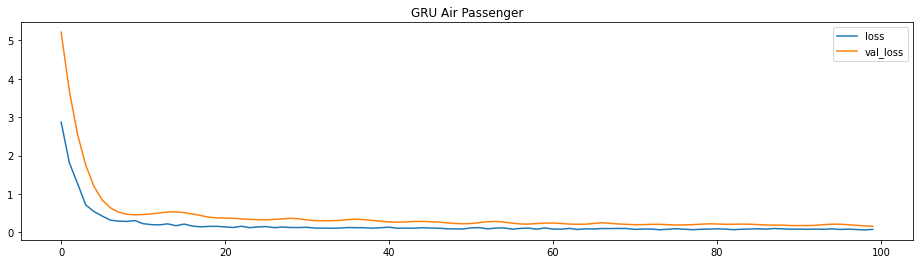

In [162]:
pd.DataFrame(history_a_m.history).plot(title='GRU Air Passenger')

In [163]:
model_a_m.evaluate(x=x_test_air, y=y_test_air)

1/1 [==============================] - 0s 16ms/step - loss: 0.8801


0.8801374435424805

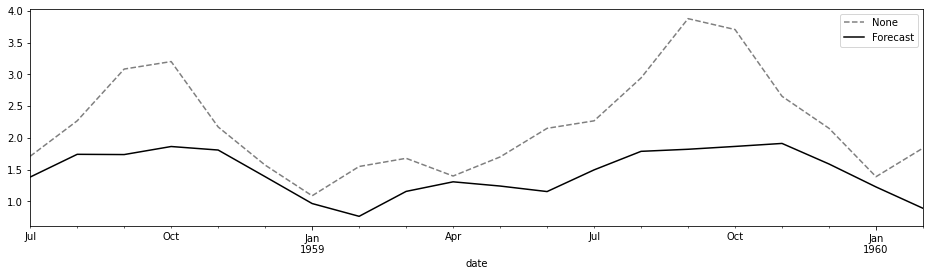

In [164]:
plot_forecast(model_a_m, x_test_air, y_test_air, test_air.index)